In [1]:
import os
from os import path
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import gym
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions.normal import Normal

from AssemblyGym.envs import FuselageActuators

def make_env(env_id, seed, idx, n_actions):
    env = gym.make(env_id, n_actuators=n_actions, mode="Surrogate", seed=seed, port=50056+idx)
    #env = gym.wrappers.RecordEpisodeStatistics(env)
    return env


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs, n_actions):
        self.n_actions = n_actions
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        # layers for self.actor_mean
        self.fc1 = layer_init(nn.Linear(np.array(envs.observation_space.shape).prod(), 64))
        self.fc2 = layer_init(nn.Linear(64, 64))
        self.fc3 = layer_init(nn.Linear(64, np.prod(envs.action_space.shape)), std=0.01)
        
        self.actor_logstd = nn.Parameter(-5*torch.ones(1, np.prod(envs.action_space.shape)))  # initial action_std = exp(actor_logstd)

    def get_value(self, obs):
        return self.critic(obs)

    def get_action_and_value(self, obs, action=None):
        # Start with standard MLP
        x = torch.tanh(self.fc1(obs))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        # Use hardshrink to enforce max number of nonzero outputs
        idx = torch.argsort(abs(x))
        lambd = abs(x[idx[-(self.n_actions+1)]]).item()
        action_mean = F.hardshrink(x, lambd=lambd) # sets outputs whose magnitudes are smaller than lambda to zero
        # Build action distribution
        action_logstd = self.actor_logstd#.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            action = probs.sample()
        if action == "deterministic":
            action = action_mean
        return action_mean, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.critic(obs)

# Make the environment (test mode)
env_name = "FuselageActuators-v22"
run_name = "dummy"
envs = make_env(env_name, 0 , 0, 10)


# Create agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = Agent(envs, 10).to(device)
agent.load_state_dict(torch.load(
            "./wandb/run-20230202_201959-1rw7aiak/files/agent_16383936steps.pt", map_location=device))

c:\Users\TL\Documents\PythonVENV\venv3_10-pyAnsys\lib\site-packages\scooby\knowledge.py:14: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
  import distutils.sysconfig as sysconfig
c:\Users\TL\Documents\PythonVENV\venv3_10-pyAnsys\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\TL\Documents\PythonVENV\venv3_10-pyAnsys\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


<All keys matched successfully>

# Figure 1 (Reward Function)

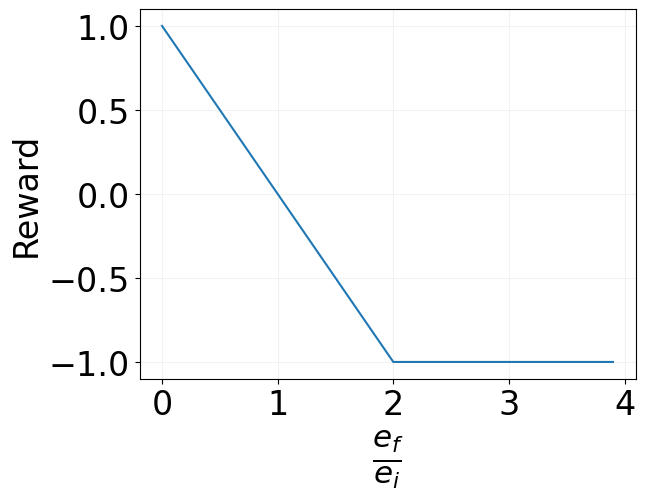

In [21]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
x = np.arange(0, 4, 0.1)
y= np.maximum(1-x, -np.ones_like(x))

ax.plot(x, y, "-")
plt.rcParams['font.size'] = '20'
ax.set(ylabel='Reward', xlabel=r'$\frac{e_{f}}{e_{i}}$')
ax.xaxis.label.set_size(32)
plt.grid(axis='both', color='0.95')

plt.savefig("./Figures/Figure1-R2.png")

In [3]:
agent.actor_logstd

Parameter containing:
tensor([[-5.7816, -6.2564, -6.2128, -5.9645, -5.5102, -5.2835, -4.9159, -4.4634,
         -4.3606, -4.3383, -4.4471, -4.9160, -5.2837, -5.7473, -6.0085, -6.2239,
         -6.3049, -6.3802]], device='cuda:0', requires_grad=True)

In [9]:
print(list(agent.parameters()))

[Parameter containing:
tensor([[-5.7816, -6.2564, -6.2128, -5.9645, -5.5102, -5.2835, -4.9159, -4.4634,
         -4.3606, -4.3383, -4.4471, -4.9160, -5.2837, -5.7473, -6.0085, -6.2239,
         -6.3049, -6.3802]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[ 0.0402, -0.0161,  0.0816,  ...,  0.0255,  0.0440,  0.0368],
        [ 0.0706, -0.0575, -0.0974,  ..., -0.0056,  0.0127, -0.0522],
        [-0.0281,  0.0211,  0.0597,  ...,  0.0491,  0.0577,  0.0351],
        ...,
        [ 0.0311,  0.0182,  0.0796,  ...,  0.0349,  0.1360, -0.0634],
        [-0.0362,  0.0193, -0.1459,  ..., -0.0365, -0.0519,  0.0538],
        [ 0.0189, -0.0586, -0.0878,  ..., -0.0448, -0.0157, -0.0104]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.1155,  0.0753, -0.0395, -0.0907,  0.1655,  0.1204, -0.0003, -0.1114,
         0.0389,  0.0710,  0.0609, -0.0401, -0.0903,  0.0163, -0.0035,  0.0471,
        -0.1953, -0.1663, -0.0097, -0.1157,  0.1492,  0.0473,  0.

In [8]:
agent.actor_logstd

Parameter containing:
tensor([[-5.7816, -6.2564, -6.2128, -5.9645, -5.5102, -5.2835, -4.9159, -4.4634,
         -4.3606, -4.3383, -4.4471, -4.9160, -5.2837, -5.7473, -6.0085, -6.2239,
         -6.3049, -6.3802]], device='cuda:0', requires_grad=True)

# Figure 2 (Action variation figures)

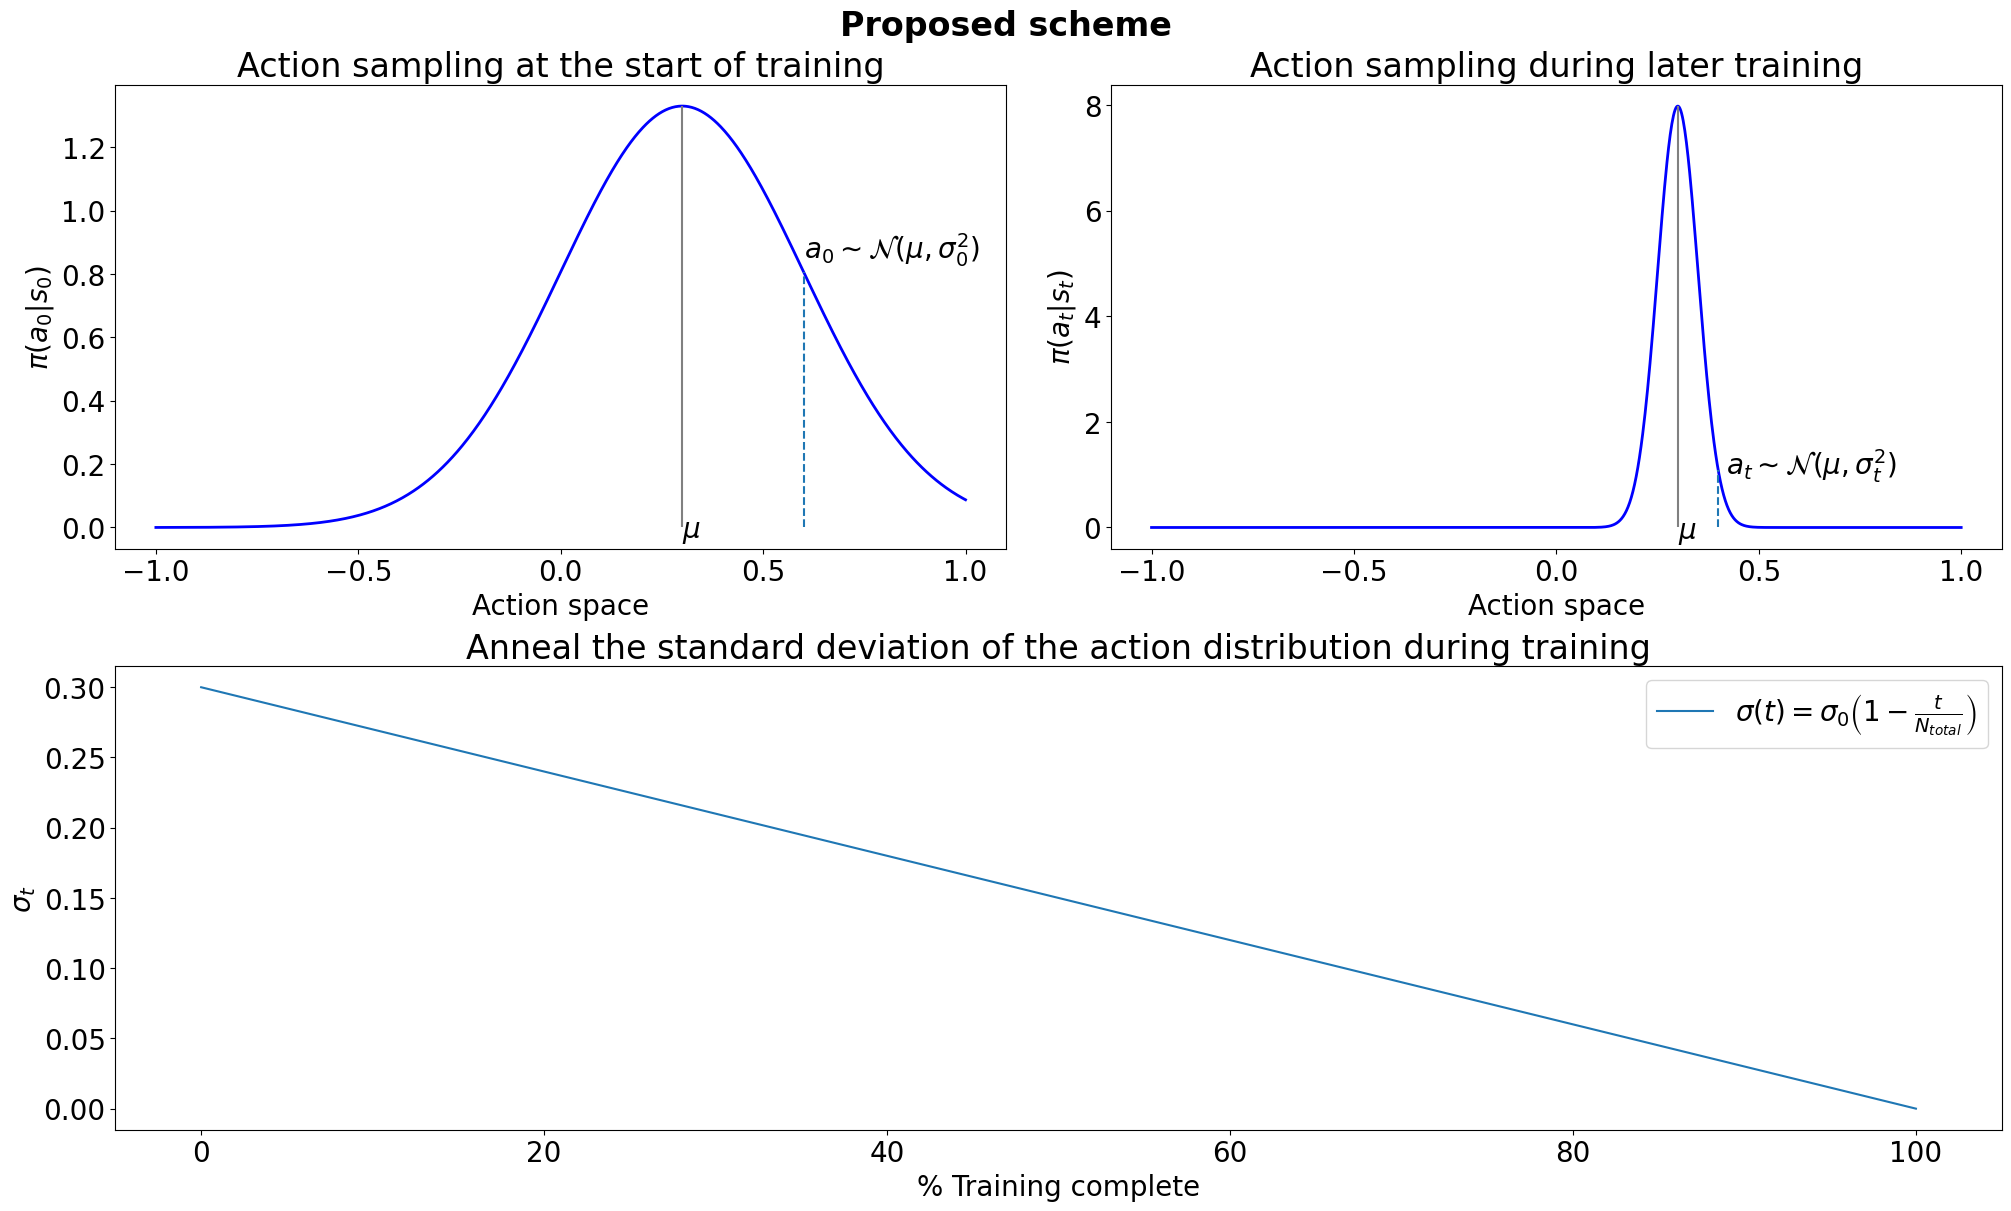

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import numpy as np

mu, sigma1, sigma2 = 0.3, 0.3, 0.05

# fig, [ax1, ax2, ax3] = plt.subplots(1,3,figsize=(18, 12))

fig = plt.figure(layout="constrained",figsize=(20, 12))
spec = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(spec[0, 0])

ax2 = fig.add_subplot(spec[0, 1])


# ax3 = fig.add_subplot(spec[0, 2])

ax4 = fig.add_subplot(spec[1,:2])


plt.rcParams.update({'font.size': 20})
fig.suptitle('Proposed scheme', fontsize=24, fontweight='bold')


x = np.linspace(-1,1,1000)
y1 = 1/(sigma1 * np.sqrt(2 * np.pi)) *np.exp( - (x - mu)**2 / (2 * sigma1**2))
ymu = 1/(sigma1 * np.sqrt(2 * np.pi)) *np.exp( - (mu - mu)**2 / (2 * sigma1**2))
ax1.plot(x, y1 , linewidth=2, color='b')
ax1.vlines(mu, 0, ymu, color='grey')
ax1.vlines(0.6, 0 , 1/(sigma1 * np.sqrt(2 * np.pi)) *np.exp( - (0.6 - mu)**2 / (2 * sigma1**2)), linestyles='dashed', label=r'$a~Normal(\mu, \sigma)$')
ax1.annotate(r'$a_0 \sim \mathcal{N}(\mu, \sigma_0^2)$', xy=(0.6,0.85))
ax1.annotate(r'$\mu$', xy=(mu, -0.03))
ax1.set_title("Action sampling at the start of training")
ax1.set_xlabel("Action space")
ax1.set_ylabel("$\pi(a_0|s_0)$")
ax1.set_xticks(np.arange(-1, 1.01, 0.5))

y2 = 1/(sigma2 * np.sqrt(2 * np.pi)) *np.exp( - (x - mu)**2 / (2 * sigma2**2))
ymu = 1/(sigma2 * np.sqrt(2 * np.pi)) *np.exp( - (mu - mu)**2 / (2 * sigma2**2))
ax2.plot(x, y2 , linewidth=2, color='b')
ax2.vlines(mu, 0, ymu, color='grey')
ax2.vlines(0.4, 0 , 1/(sigma2 * np.sqrt(2 * np.pi)) *np.exp( - (0.4 - mu)**2 / (2 * sigma2**2)), linestyles='dashed', label=r'$a~Normal(\mu, \sigma)$')
ax2.set_title("Action sampling during later training")
ax2.set_xlabel("Action space")
ax2.set_ylabel("$\pi(a_t|s_t)$")
ax2.annotate(r'$\mu$', xy=(mu, -0.2))
ax2.annotate(r'$a_t \sim \mathcal{N}(\mu, \sigma_t^2)$', xy=(0.42,1))
ax2.set_xticks(np.arange(-1, 1.01, 0.5))

# ax3.vlines(mu, 0, 100, color='b')
# ax3.set_xlim([-1,1])
# ax3.set_title("Action sampling during testing")
# ax3.annotate(r'$a = \mu$', xy=(mu, 101))

x4 = np.linspace(0,100)
y4 = sigma1*(1-x4/100)
ax4.plot(x4,y4,'-', label=r'$\sigma(t) = \sigma_0\left(1-\frac{t}{N_{total}}\right)$')
ax4.set_xlabel('% Training complete')
ax4.set_ylabel(r'$\sigma_t$')
ax4.legend()
ax4.set_title('Anneal the standard deviation of the action distribution during training')
plt.show()

plt.savefig("./Figures/Figure2-R2.png")

Proposed scheme: make $\sigma$ a function of training timesteps

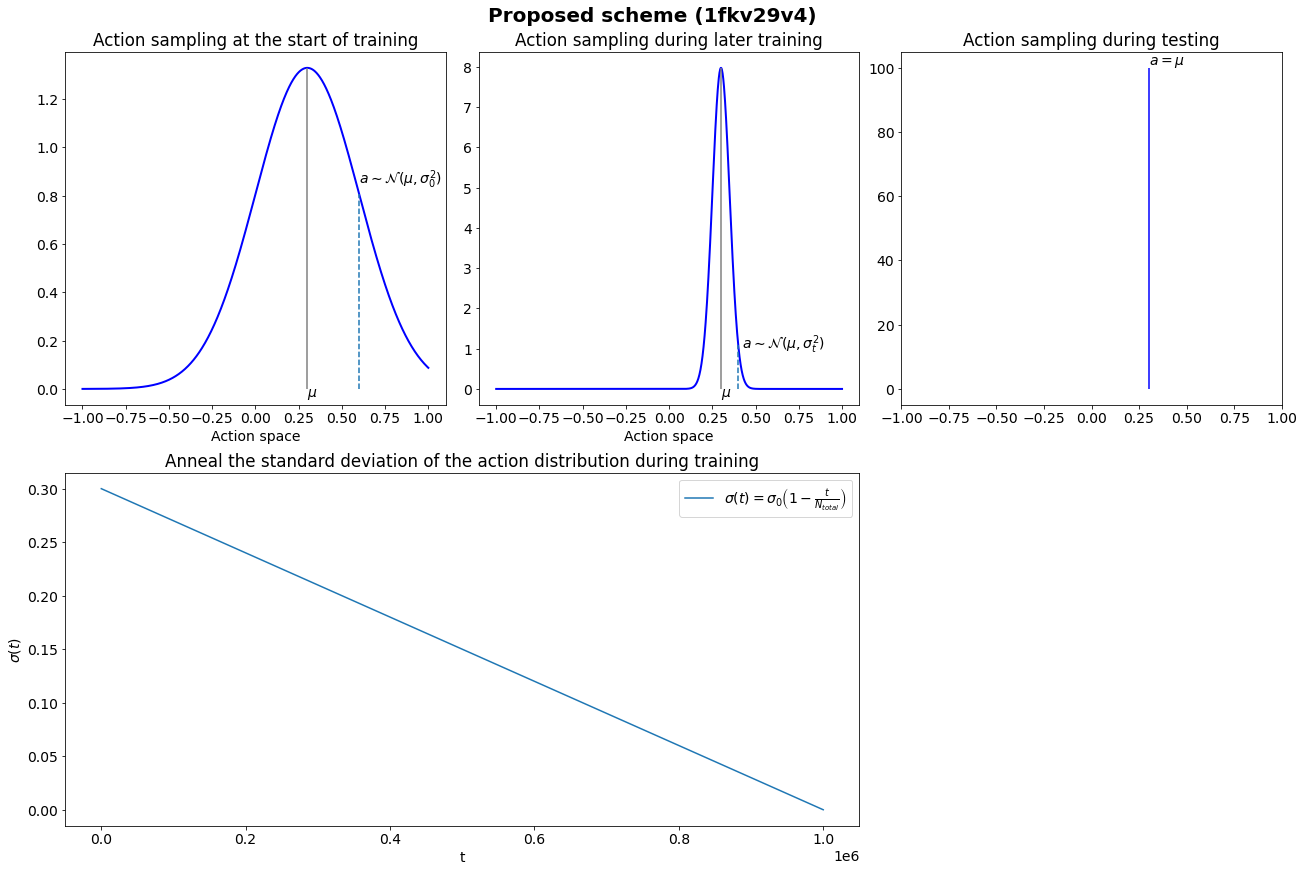

In [129]:
import matplotlib.pyplot as plt
import numpy as np

mu, sigma1, sigma2 = 0.3, 0.3, 0.05

# fig, [ax1, ax2, ax3] = plt.subplots(1,3,figsize=(18, 12))

fig = plt.figure(layout="constrained",figsize=(18, 12))
spec = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(spec[0, 0])

ax2 = fig.add_subplot(spec[0, 1])


ax3 = fig.add_subplot(spec[0, 2])

ax4 = fig.add_subplot(spec[1,:2])


plt.rcParams.update({'font.size': 14})
fig.suptitle('Proposed scheme (1fkv29v4)', fontsize=20, fontweight='bold')


x = np.linspace(-1,1,1000)
y1 = 1/(sigma1 * np.sqrt(2 * np.pi)) *np.exp( - (x - mu)**2 / (2 * sigma1**2))
ymu = 1/(sigma1 * np.sqrt(2 * np.pi)) *np.exp( - (mu - mu)**2 / (2 * sigma1**2))
ax1.plot(x, y1 , linewidth=2, color='b')
ax1.vlines(mu, 0, ymu, color='grey')
ax1.vlines(0.6, 0 , 1/(sigma1 * np.sqrt(2 * np.pi)) *np.exp( - (0.6 - mu)**2 / (2 * sigma1**2)), linestyles='dashed', label=r'$a~Normal(\mu, \sigma)$')
ax1.annotate(r'$a \sim \mathcal{N}(\mu, \sigma_0^2)$', xy=(0.6,0.85))
ax1.annotate(r'$\mu$', xy=(mu, -0.03))
ax1.set_title("Action sampling at the start of training")
ax1.set_xlabel("Action space")

y2 = 1/(sigma2 * np.sqrt(2 * np.pi)) *np.exp( - (x - mu)**2 / (2 * sigma2**2))
ymu = 1/(sigma2 * np.sqrt(2 * np.pi)) *np.exp( - (mu - mu)**2 / (2 * sigma2**2))
ax2.plot(x, y2 , linewidth=2, color='b')
ax2.vlines(mu, 0, ymu, color='grey')
ax2.vlines(0.4, 0 , 1/(sigma2 * np.sqrt(2 * np.pi)) *np.exp( - (0.4 - mu)**2 / (2 * sigma2**2)), linestyles='dashed', label=r'$a~Normal(\mu, \sigma)$')
ax2.set_title("Action sampling during later training")
ax2.set_xlabel("Action space")
ax2.annotate(r'$\mu$', xy=(mu, -0.2))
ax2.annotate(r'$a \sim \mathcal{N}(\mu, \sigma_t^2)$', xy=(0.42,1))

ax3.vlines(mu, 0, 100, color='b')
ax3.set_xlim([-1,1])
ax3.set_title("Action sampling during testing")
ax3.annotate(r'$a = \mu$', xy=(mu, 101))

x4 = np.linspace(0,1000000)
y4 = sigma1*(1-x4/1000000)
ax4.plot(x4,y4,'-', label=r'$\sigma(t) = \sigma_0\left(1-\frac{t}{N_{total}}\right)$')
ax4.set_xlabel('t')
ax4.set_ylabel(r'$\sigma(t)$')
ax4.legend()
ax4.set_title('Anneal the standard deviation of the action distribution during training')
plt.show()


Old scheme: $\sigma$ is constant

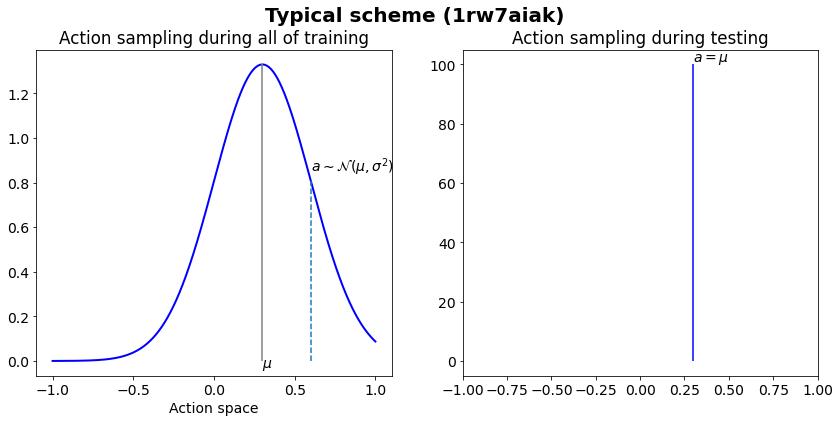

In [127]:
import matplotlib.pyplot as plt
import numpy as np

mu, sigma1, sigma2 = 0.3, 0.3, 0.05

fig, [ax1, ax3] = plt.subplots(1,2,figsize=(14, 6))
plt.rcParams.update({'font.size': 14})
fig.suptitle('Typical scheme (1rw7aiak)', fontsize=20, fontweight='bold')

x = np.linspace(-1,1,1000)
y1 = 1/(sigma1 * np.sqrt(2 * np.pi)) *np.exp( - (x - mu)**2 / (2 * sigma1**2))
ymu = 1/(sigma1 * np.sqrt(2 * np.pi)) *np.exp( - (mu - mu)**2 / (2 * sigma1**2))
ax1.plot(x, y1 , linewidth=2, color='b')
ax1.vlines(mu, 0, ymu, color='grey')
ax1.vlines(0.6, 0 , 1/(sigma1 * np.sqrt(2 * np.pi)) *np.exp( - (0.6 - mu)**2 / (2 * sigma1**2)), linestyles='dashed', label=r'$a~Normal(\mu, \sigma)$')
ax1.annotate(r'$a \sim \mathcal{N}(\mu, \sigma^2)$', xy=(0.6,0.85))
ax1.annotate(r'$\mu$', xy=(mu, -0.03))
ax1.set_title("Action sampling during all of training")
ax1.set_xlabel("Action space")


ax3.vlines(mu, 0, 100, color='b')
ax3.set_xlim([-1,1])
ax3.set_title("Action sampling during testing")
ax3.annotate(r'$a = \mu$', xy=(mu, 101))
plt.show()


# Action variation comparison figures

In [16]:
import pandas as pd
import numpy as np

df1 = pd.read_csv("eval final error.csv")


In [17]:
eval_error1 = df1["FuselageActuators-v22__ppo_FuselageActuators_v22_surrogate_annealActorStd__1__1676657875 - eval/final_error"]
np.mean(eval_error)

0.01387819850620504

In [18]:
eval_error2 = df1["FuselageActuators-v22__ppo_FuselageActuators_v22_surrogate_annealActorStd__1__1676908289 - eval/final_error"]
np.mean(eval_error)

0.01387819850620504

## Training

In [27]:
df1 = pd.read_csv("training final error.csv")
df1

,global_step,1fkv29v4(annealing action variation),1fkv29v4(annealing action variation)__MIN,1fkv29v4(annealing action variation)__MAX,1w9xz3oi(constant action variation),1w9xz3oi(constant action variation)__MIN,1w9xz3oi(constant action variation)__MAX
0,1548,NaN,NaN,NaN,4.887109e+01,0.742185,97.0
1,2700,NaN,NaN,NaN,8.483665e+01,0.673306,169.0
2,3468,NaN,NaN,NaN,1.087631e+02,0.526157,217.0
3,3852,1.208818e+02,0.763591,241.0,NaN,NaN,NaN
4,6348,1.987872e+02,0.574365,397.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
24185,32754444,1.023577e+06,0.012383,2047153.0,NaN,NaN,NaN
24186,32755212,1.023601e+06,0.013084,2047201.0,NaN,NaN,NaN
24187,32761548,NaN,NaN,NaN,1.023799e+06,0.019534,2047597.0
24188,32762508,1.023829e+06,0.012951,2047657.0,NaN,NaN,NaN


In [61]:
error_1fkv29v4 = df1["1fkv29v4(annealing action variation)__MIN"].dropna()
error_1w9xz3oi = df1["1w9xz3oi(constant action variation)__MIN"].dropna()
error_1fkv29v4

3        0.763591
4        0.574365
6        0.412293
8        0.271886
10       0.661052
           ...   
24179    0.011876
24184    0.014050
24185    0.012383
24186    0.013084
24188    0.012951
Name: 1fkv29v4(annealing action variation)__MIN, Length: 12410, dtype: float64

In [45]:
step_1fkv29v4 = df1["global_step"][df1["1fkv29v4(annealing action variation)"].notna()]
step_1w9xz3oi = df1["global_step"][df1["1w9xz3oi(constant action variation)"].notna()]
step_1fkv29v4

3            3852
4            6348
6            7308
8            8844
10          13452
           ...   
24179    32747532
24184    32753292
24185    32754444
24186    32755212
24188    32762508
Name: global_step, Length: 12410, dtype: int64

In [32]:
error_1w9xz3oi

0        4.887109e+01
1        8.483665e+01
2        1.087631e+02
5        2.108223e+02
7        2.648035e+02
             ...     
24181    1.023391e+06
24182    1.023475e+06
24183    1.023535e+06
24187    1.023799e+06
24189    1.023835e+06
Name: 1w9xz3oi(constant action variation), Length: 12678, dtype: float64

In [33]:
error_1fkv29v4

3        1.208818e+02
4        1.987872e+02
6        2.287061e+02
8        2.766359e+02
10       4.208305e+02
             ...     
24179    1.023361e+06
24184    1.023541e+06
24185    1.023577e+06
24186    1.023601e+06
24188    1.023829e+06
Name: 1fkv29v4(annealing action variation), Length: 12410, dtype: float64

In [110]:
ma_1fkv29v4 = pd.Series.rolling(error_1fkv29v4, 500).mean()
ma_1w9xz3oi = pd.Series.rolling(error_1w9xz3oi, 500).mean()

Text(0.5, 0, 'Training steps')

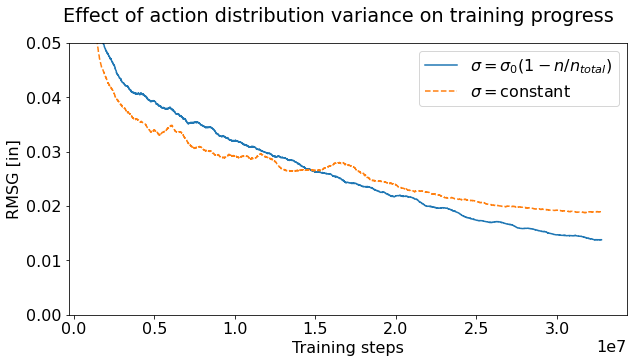

In [126]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Effect of action distribution variance on training progress")
# ax.plot(step_1fkv29v4, error_1fkv29v4)
ax.plot(step_1fkv29v4, ma_1fkv29v4, "-")
# ax.plot(step_1w9xz3oi, error_1w9xz3oi)
ax.plot(step_1w9xz3oi, ma_1w9xz3oi, "--")
ax.legend([r"$\sigma = \sigma_0(1-n/n_{total})$", r"$\sigma =$constant"])
ax.set_ylabel("RMSG [in]")
ax.set_ylim(0.0,0.05)
ax.set_xlabel("Training steps")
# ax.set_title("Training progress: annealing vs. constant action distribution variance")

# Figure 5 (Number of actions sweep)

In [7]:
import pandas as pd
import numpy as np

df1 = pd.read_csv("./Eval/N Action Sweep.csv")
df1.sort_values("n_actions", inplace=True)
df1.head()

,Name,ID,n_actions,eval/final_error.mean,Runtime,GitHub,Notes,State,Tags,actor_logstd,...,max_dev,eval/final_error,eval/init_max_dev,eval/initial_error,eval/max_dev,eval/reward,eval/step,eval/final_error.max,eval/max_dev.max,eval/max_dev.mean
0,FuselageActuators-v22__ppo_FuselageActuators_v...,12elszxg,1,0.109891,14446,https://github.com/otlutz/AssemblyGym/tree/d24...,-,finished,NaN,-5,...,0.373087,NaN,1.017473,0.524439,NaN,0.819251,99,0.299745,0.660923,0.245914
1,FuselageActuators-v22__ppo_FuselageActuators_v...,335gebbm,3,0.042276,14453,https://github.com/otlutz/AssemblyGym/tree/d24...,-,finished,NaN,-5,...,0.138271,NaN,0.643099,0.321082,NaN,0.912073,99,0.080679,0.192676,0.102841
2,FuselageActuators-v22__ppo_FuselageActuators_v...,27hgm4ca,5,0.028633,14397,https://github.com/otlutz/AssemblyGym/tree/d24...,-,finished,NaN,-5,...,0.093333,NaN,0.643099,0.321082,NaN,0.906195,99,0.058830,0.153260,0.077752
11,FuselageActuators-v22__ppo_FuselageActuators_v...,17lnk9fw,6,0.027982,14491,https://github.com/otlutz/AssemblyGym/tree/d24...,-,finished,NaN,-5,...,0.083940,NaN,1.017473,0.524439,NaN,0.917888,99,0.055664,0.158120,0.077114
3,FuselageActuators-v22__ppo_FuselageActuators_v...,2g7xfij2,7,0.022851,14407,https://github.com/otlutz/AssemblyGym/tree/d24...,-,finished,NaN,-5,...,0.082324,NaN,1.017473,0.524439,NaN,0.951581,99,0.053420,0.158143,0.064600


Text(0.5, 0, 'Number of actions')

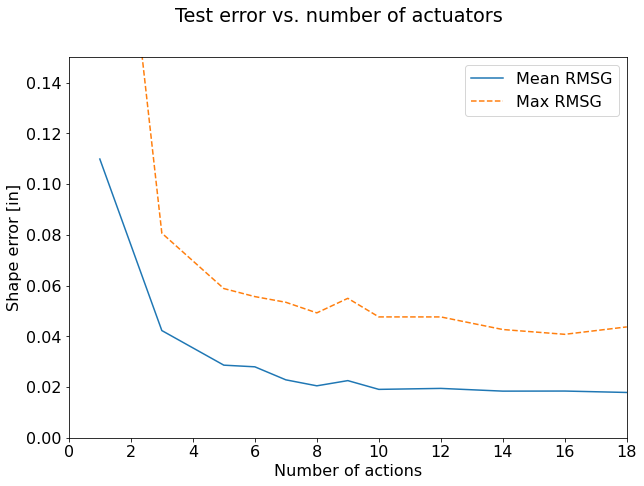

In [8]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 7))
fig.suptitle("Test error vs. number of actuators")

ax.plot(df1["n_actions"], df1["eval/final_error.mean"], "-")
ax.plot(df1["n_actions"], df1["eval/final_error.max"], "--")
ax.legend([r"Mean RMSG", r"Max RMSG"])
ax.set_ylabel("Shape error [in]")
ax.set_ylim(0.0,0.15)
ax.set_xlim(0,18)
ax.set_xlabel("Number of actions")
# ax.set_title("Training progress: annealing vs. constant action distribution variance")

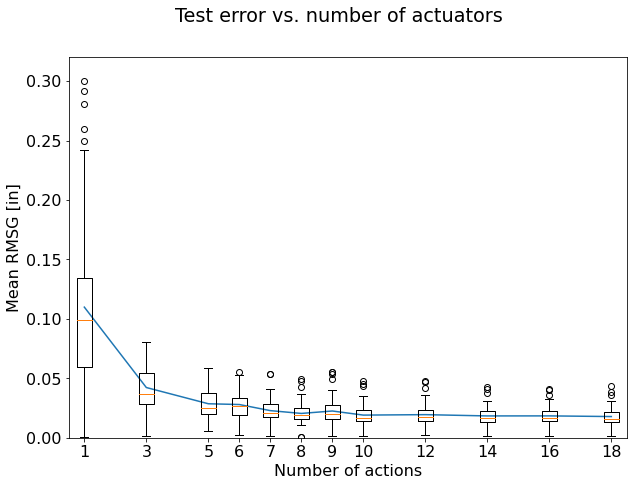

In [10]:
import matplotlib.pyplot as plt
import pandas as pd


df01 = pd.read_csv("Eval/Mean RMSG 01 Actuators.csv")
df03 = pd.read_csv("Eval/Mean RMSG 03 Actuators.csv")
df05 = pd.read_csv("Eval/Mean RMSG 05 Actuators.csv")
df06 = pd.read_csv("Eval/Mean RMSG 06 Actuators.csv")
df07 = pd.read_csv("Eval/Mean RMSG 07 Actuators.csv")
df08 = pd.read_csv("Eval/Mean RMSG 08 Actuators.csv")
df09 = pd.read_csv("Eval/Mean RMSG 09 Actuators.csv")
df10 = pd.read_csv("Eval/Mean RMSG 10 Actuators.csv")
df12 = pd.read_csv("Eval/Mean RMSG 12 Actuators.csv")
df14 = pd.read_csv("Eval/Mean RMSG 14 Actuators.csv")
df16 = pd.read_csv("Eval/Mean RMSG 16 Actuators.csv")
df18 = pd.read_csv("Eval/Mean RMSG 18 Actuators.csv")

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 7))
fig.suptitle("Test error vs. number of actuators")

ax.plot(df1["n_actions"], df1["eval/final_error.mean"], "-")
ax.set_ylabel("Mean RMSG [in]")
ax.set_ylim(0.0,0.32)
ax.set_xlabel("Number of actions")

# Save the default tick positions, so we can reset them...
locs, labels = plt.xticks() 

# Add boxplots
ax.boxplot([df01.iloc[:,4],
            df03.iloc[:,4],
            df05.iloc[:,4],
            df06.iloc[:,4],
            df07.iloc[:,4],
            df08.iloc[:,4],
            df09.iloc[:,4],
            df10.iloc[:,4],
            df12.iloc[:,4],
            df14.iloc[:,4],
            df16.iloc[:,4],
            df18.iloc[:,4]],
            positions=[1,3,5,6,7,8,9,10,12,14,16,18])

#ax.set_ylim(0.03,0.06)
ax.set_xlabel("Number of actions")

plt.savefig("./Figures/Figure5.png")

Text(0.5, 0, 'Number of actions')

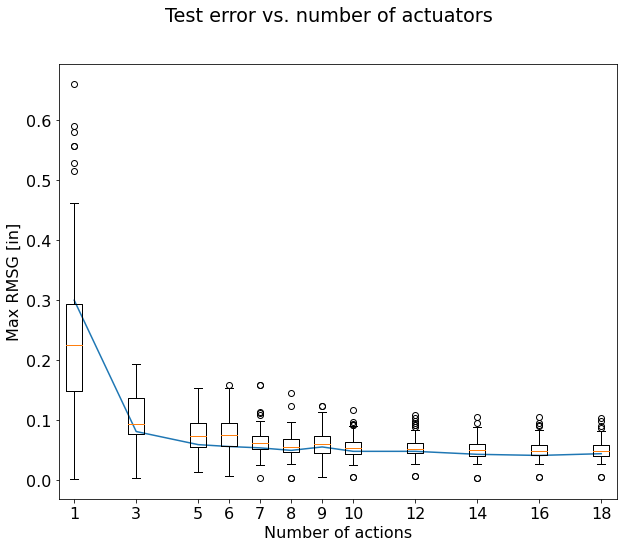

In [11]:
import matplotlib.pyplot as plt

df01 = pd.read_csv("Eval/Max RMSG 01 Actuators.csv")
df03 = pd.read_csv("Eval/Max RMSG 03 Actuators.csv")
df05 = pd.read_csv("Eval/Max RMSG 05 Actuators.csv")
df06 = pd.read_csv("Eval/Max RMSG 06 Actuators.csv")
df07 = pd.read_csv("Eval/Max RMSG 07 Actuators.csv")
df08 = pd.read_csv("Eval/Max RMSG 08 Actuators.csv")
df09 = pd.read_csv("Eval/Max RMSG 09 Actuators.csv")
df10 = pd.read_csv("Eval/Max RMSG 10 Actuators.csv")
df12 = pd.read_csv("Eval/Max RMSG 12 Actuators.csv")
df14 = pd.read_csv("Eval/Max RMSG 14 Actuators.csv")
df16 = pd.read_csv("Eval/Max RMSG 16 Actuators.csv")
df18 = pd.read_csv("Eval/Max RMSG 18 Actuators.csv")

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Test error vs. number of actuators")

# Line plot
ax.plot(df1["n_actions"], df1["eval/final_error.max"], "-")
# Add boxplots
ax.boxplot([df01.iloc[:,4],
            df03.iloc[:,4],
            df05.iloc[:,4],
            df06.iloc[:,4],
            df07.iloc[:,4],
            df08.iloc[:,4],
            df09.iloc[:,4],
            df10.iloc[:,4],
            df12.iloc[:,4],
            df14.iloc[:,4],
            df16.iloc[:,4],
            df18.iloc[:,4]],
            positions=[1,3,5,6,7,8,9,10,12,14,16,18])

ax.set_ylabel("Max RMSG [in]")
ax.set_xlabel("Number of actions")

# Figure 7 (Comparison entropy loss vs annealing)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df1 = pd.read_csv("./Annealing/training final error.csv")
df2 = pd.read_csv("./Annealing/training episodic return.csv")
df1.columns[1]

runs = df1.columns[2::3]
runs

Index(['1s6mr4pf(-)__MIN', '3e1nfbiz(-)__MIN', '305a4xh1(-)__MIN',
       '3c4umcd8(-)__MIN', '2ojwefjw(-)__MIN', '27e6khf3(-)__MIN'],
      dtype='object')

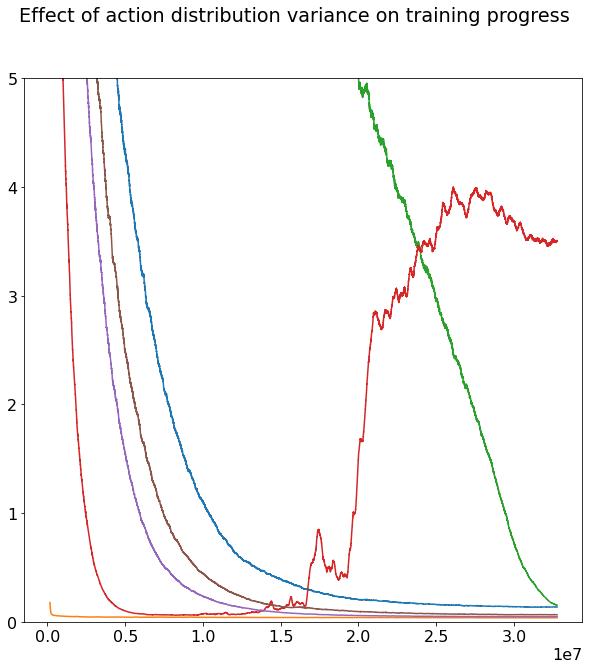

In [3]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle("Effect of action distribution variance on training progress")
# ax.plot(step_1fkv29v4, error_1fkv29v4)
# ax.plot(step_1fkv29v4, ma_1fkv29v4, "-")
# # ax.plot(step_1w9xz3oi, error_1w9xz3oi)
# ax.plot(step_1w9xz3oi, ma_1w9xz3oi, "--")

for run in runs:
    step = df1["global_step"][df1[run].notna()]
    error = df1[run].dropna()
    ma = pd.Series.rolling(error, 500).mean()
    ax.plot(step, ma)


# ax.legend([r"$\sigma = \sigma_0(1-n/n_{total})$", r"$\sigma =$constant"])
# ax.set_ylabel("RMSG [in]")
ax.set_ylim(0.0,5)
# ax.set_xlabel("Training steps")
plt.show()


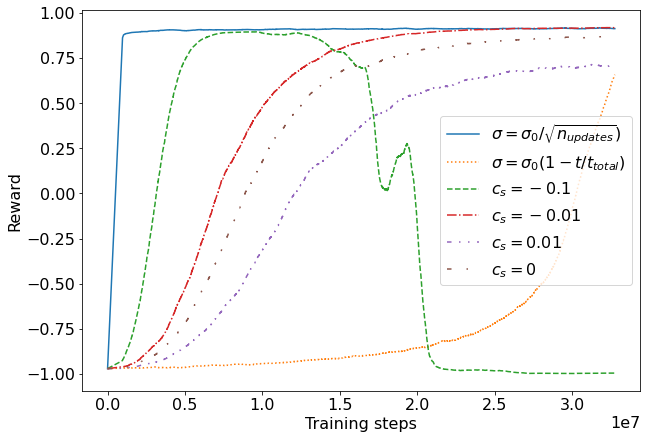

<Figure size 432x288 with 0 Axes>

In [82]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 7))
# fig.suptitle("Annealing the standard deviation of the action distribution compared to entropy loss")

run_indices=[1,2,3,4,0,5]
markers = [".", "x", "*", "o", "D", "^"]
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10, 1, 10))]
for i in range(len(runs)):
    step = df2["global_step"][df2[runs[run_indices[i]]].notna()]
    # step.loc[0]=0
    # step.sort_values(ascending=True, inplace=True)
    reward = df2[runs[run_indices[i]]].dropna()
    # reward.loc[0]=-1
    # reward = reward.sort_values(ascending=True)
    ma = pd.Series.rolling(reward, 1000).mean()
    ax.plot(np.append([0], step[~np.isnan(ma.values)].values),np.append([-.97], ma[~np.isnan(ma.values)].values), linestyle=linestyles[i])#, linestyle=(0, (5, 10)))

ax.legend([r"$\sigma = \sigma_0/\sqrt{n_{updates}})$", r"$\sigma = \sigma_0(1-t/t_{total})$", r"$c_s=-0.1$", r"$c_s=-0.01$", r"$c_s=0.01$", r"$c_s=0$"], loc='right')
ax.set_ylabel("Reward")
# ax.set_ylim(-1,1)
ax.set_xlabel("Training steps")
plt.show()

plt.savefig("./Figures/Figure7.png")

In [73]:
ma[~np.isnan(ma.values)].values

array([-0.96661335, -0.96660723, -0.96659455, ...,  0.86460831,
        0.86467874,  0.864659  ])

In [74]:
step[~np.isnan(ma.values)].values

array([  906828,   907404,   907596, ..., 32764812, 32765964, 32767500],
      dtype=int64)